In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import pandas as pd
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature


/home/b/b382718/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:

ds_dcmex_1mom_1 = xr.open_mfdataset('/work/bb1163/b382718/output/dcmex/nested_run/icon_output/from_horeka/r3b10/1mom/20220802_0803/NWP_LAM_icongrid_DOM01_2022080*T*Z.nc');

data_dcmex_1mom = ds_dcmex_1mom_1 #xr.concat([ds_dcmex_1mom_1, ds_dcmex_1mom_2], dim="time")

ds_dcmex_2mom_1 = xr.open_mfdataset('/work/bb1163/b382718/output/dcmex/nested_run/icon_output/from_horeka/r3b10/2mom/20220802_0803/NWP_LAM_icongrid_DOM01_2022080*T*Z.nc');

data_dcmex_2mom = ds_dcmex_2mom_1 #xr.concat([ds_dcmex_2mom_1, ds_dcmex_2mom_2], dim="time")


In [3]:

grid_dcmex = xr.open_dataset('/work/bb1163/b382718/output/dcmex/nested_run/icon_output/from_horeka/r3b10/1mom/20220725_0726/domain1_DOM01.nc');


In [4]:

clon_deg = np.degrees(grid_dcmex.clon)
clat_deg = np.degrees(grid_dcmex.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([-107., 34.])
#print(okla_x), print(okla_y)
dx_deg = 0.5; dy_deg = 0.5
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)

window_cell = (
    (grid_dcmex.clat >= np.deg2rad(bottom_bound))
    & (grid_dcmex.clat <= np.deg2rad(top_bound))
    & (grid_dcmex.clon >= np.deg2rad(left_bound))
    & (grid_dcmex.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_dcmex.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_dcmex.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)

vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid



-109.03361083589718
-104.96568072774484
31.965728856399803
36.03463183523589
-107.5
-106.5
34.5
33.5
window_vertex_indices :: [ 4032  4035  4043 ... 34011 34012 34013]
window_edge_indices :: [ 16084  16085  16086 ... 101083 101084 101085]


In [5]:

new_grid_dcmex = reindex_grid(grid_dcmex, selected_indices, vars_to_renumber)

mask=np.isin(data_dcmex_1mom['ncells'], selected_indices.cell)
mask_cell = mask


In [6]:

aircraft_starttime='2022-08-02T15:00:00.000000000'
aircraft_endtime='2022-08-03T21:00:00.000000000'

ds_1mom_new = data_dcmex_1mom.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_2mom_new = data_dcmex_2mom.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [7]:

ds_2mom_new['tot_nice_perl'] = (ds_2mom_new.qni+ds_2mom_new.qns+
                                ds_2mom_new.qng+ds_2mom_new.qnh)*ds_2mom_new.rho*1.e-3 # perkg to perl

ds_2mom_new['w_vel'] = -1.*ds_2mom_new.omega/(9.8*ds_2mom_new.rho)
ds_2mom_new['tempc'] = ds_2mom_new.temp-273.16;

ds_2mom_new['lwc_gperm3']  = ds_2mom_new.qc*ds_2mom_new.rho*1.e3 # kgperm3 to gperm3
ds_2mom_new['ciwc_gperm3'] = ds_2mom_new.qi*ds_2mom_new.rho*1.e3 # kgperm3 to gperm3
ds_2mom_new['tqi'] = ds_2mom_new.qi+ds_2mom_new.qs+ds_2mom_new.qg+ds_2mom_new.qh
ds_2mom_new['tiwc_gperm3'] = (ds_2mom_new.qi+ds_2mom_new.qs+ds_2mom_new.qg+ds_2mom_new.qh)*ds_2mom_new.rho*1.e3 # kgperm3 to gperm3
ds_2mom_new['cdnc_percm3'] = ds_2mom_new.qnc*ds_2mom_new.rho*1.e-6  # perkg to percm3


In [8]:


file = open('/work/bb1163/b382718/output/dcmex/observations/airborne_inp/02_INP_data_teflon.csv'); 

data_teflon_inp = pd.read_csv('/work/bb1163/b382718/output/dcmex/observations/airborne_inp/02_INP_data_teflon.csv');
data_polycar_inp = pd.read_csv('/work/bb1163/b382718/output/dcmex/observations/airborne_inp/03_INP_data_polycarbonate.csv');

#print(data_teflon_inp)
sample_tef = data_teflon_inp['Sample'];
drop_freeze_tef_temp_degC = data_teflon_inp['Droplet freezing temp'];
fract_frozen = data_teflon_inp['Fraction frozen'];
teflon_inp_perl = data_teflon_inp['INP(L-1)'];
upper_error_inp = data_teflon_inp['INP upper error bar'];
lower_error_inp = data_teflon_inp['INP lower error bar'];

sample_polycar = data_polycar_inp['Sample'];
drop_freeze_polycar_temp_degC = data_polycar_inp['Droplet freezing temp'];
fract_frozen = data_polycar_inp['Fraction frozen'];
polycar_inp_perl = data_polycar_inp['INP(L-1)'];
polycar_upper_error_inp = data_polycar_inp['INP upper error bar'];
polycar_lower_error_inp = data_polycar_inp['INP lower error bar'];


In [9]:


temp_bin = [0., -2., -4., -6., -8., -10., -12., -14., -16., -18., -20., -22., -24., -26., -28., -30., -32., -34., -36.];

mean_tef_inp_perl = []; tef_inp_med = []; tef_inp_std_dev = [];
for i in range(len(temp_bin)-1):
    mask = (drop_freeze_tef_temp_degC >= temp_bin[i+1]) & (drop_freeze_tef_temp_degC < temp_bin[i])
    mean_tef_inp_perl.append(np.mean(teflon_inp_perl[mask]))
    tef_inp_med.append(np.nanmedian(mean_tef_inp_perl))
    tef_inp_std_dev.append(np.nanstd(mean_tef_inp_perl))


# Calculate statistics
tef_inp_std_err = tef_inp_std_dev/np.sqrt(len(mean_tef_inp_perl))

mean_polycar_inp_perl = []; polycar_inp_med = []; polycar_inp_std_dev = [];
for i in range(len(temp_bin)-1):
    mask = (drop_freeze_polycar_temp_degC >= temp_bin[i+1]) & (drop_freeze_polycar_temp_degC < temp_bin[i])
    mean_polycar_inp_perl.append(np.mean(polycar_inp_perl[mask]))
    polycar_inp_med.append(np.nanmedian(mean_polycar_inp_perl))
    polycar_inp_std_dev.append(np.nanstd(mean_polycar_inp_perl))


# Calculate statistics
tef_inp_std_err = tef_inp_std_dev/np.sqrt(len(mean_tef_inp_perl))


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
import h5py

# Open the NetCDF file using h5py
with h5py.File('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core-cloud-phy_faam_20220802_v601_r0_c310.nc', 'r') as f:
    # Print all group names in the file
    print(f.visititems(lambda name, obj: print(name)))

In [10]:
####################### Aircraft observation analysis #######################
import netCDF4

data_faam_core_cld_phy_latlon = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core-cloud-phy_faam_20220802_v602_r1_c310.nc');
data_faam_core_cld_phy = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core-cloud-phy_faam_20220802_v503_r1_c310.nc')
#print(data_faam_core.time)

time_faam_core_cld_phy = data_faam_core_cld_phy['Time'];
lon_faam_core_cld_phy = data_faam_core_cld_phy_latlon['longitude'];
lat_faam_core_cld_phy = data_faam_core_cld_phy_latlon['latitude'];
alt_faam_core_cld_phy = data_faam_core_cld_phy_latlon['altitude'];
#cdp_conc_faam_core_cld_phy = data_faam_core_cld_phy['cdp_conc'];
#print(time_faam_core)
print('')
data_faam_hvps = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/man-hvps_faam_20220802_v001_r0_c310.nc');
data_faam_cpi  = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/man-cpi_faam_20220802_v001_c310.nc');
data_faam_2ds  = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/man-2ds_faam_20220802_v001_r0_c310.nc')
data_faam_core = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core_faam_20220802_v005_r0_c310.nc');

data_faam_nevrozov = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/metoffice-nevzorov_faam_20220802_r0_c310_1hz.nc');
data_faam_core_1hz = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core_faam_20220802_v005_r0_c310_1hz.nc');


time = pd.to_datetime(data_faam_cpi['time'].values)
new_time = time.map(lambda t: t.replace(year=2022,day=2))
data_faam_cpi['time'] = new_time

time_cpi = pd.to_datetime(data_faam_cpi['time'].values)

# Set the nanoseconds part to zero (resetting microseconds/nanoseconds to 0)
new_time = time_cpi.map(lambda t: t.replace(microsecond=0, nanosecond=0))

# Update the time coordinate in the DataArray
data_faam_cpi['time'] = new_time

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/pdcompat.py:104: FutureWarning: Parsed string "2023/08/03 13:01:50.01S" included an un-recognized timezone "S". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  return pd.Timestamp(*args, **kwargs).as_unit("ns")
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/pdcompat.py:104: FutureWarning: Parsed string "2023/08/03 13:01:50.01S" included an un-recognized timezone "S". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  return pd.Timestamp(*args, **kwargs).as_unit("ns")


In [13]:

import matplotlib.patches as mpatches

# Validating total ice number concentrations

file_cip = '/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core-cloud-phy_faam_20220802_v602_r1_c310.nc'
ds_cip15 = xr.open_mfdataset(file_cip, group='cip_15/processed');
ds_cip100 = xr.open_mfdataset(file_cip, group='cip_100/processed');

ds_cip15['cip15_conc_bin_perl'] = ds_cip15['cip15_iwc_psd'].where(ds_cip15['cip15_iwc_psd'] != 0, np.nan)
ds_cip100['cip100_conc_bin_perl'] = ds_cip100['cip100_iwc_psd'].where(ds_cip100['cip100_iwc_psd'] != 0, np.nan)

# sum over all diameter bins
ds_cip15['tot_cip15_perl'] = ds_cip15.cip15_conc_bin_perl.sum(dim=('cip15_bin_centre'))
ds_cip100['tot_cip100_perl'] = ds_cip100.cip100_conc_bin_perl.sum(dim=('cip100_bin_centre'))

# merge cip100 and cip15
ds_cip_new = xr.merge([ds_cip15, ds_cip100])

# total cip concentrations
ds_cip_new['tot_inc_perl'] = ds_cip15['tot_cip15_perl']+ds_cip100['tot_cip100_perl']

# Need to extract temperature from core data
data_faam_core_1hz_new = data_faam_core_1hz

# ds_cip has 'time' and data_faam_core_1hz has 'Time', make it the same
data_faam_core_1hz_new = data_faam_core_1hz_new.rename({'Time': 'time'})

# CIP ice concentrations in updraft, downdraft and stratiform regions 
ds_cip_new['TAT_DI_R'] = data_faam_core_1hz_new['TAT_DI_R']
ds_cip_new['W_C'] = data_faam_core_1hz_new['W_C']
ds_cip_new['tempc'] = ds_cip_new['TAT_DI_R']-273.16

# create conditions
filt_cip15_up_cond = (ds_cip_new.tot_cip15_perl > 0.) & (ds_cip_new.W_C > 1.)
filt_cip15_dn_cond = (ds_cip_new.tot_cip15_perl > 0.) & (ds_cip_new.W_C < 1.)
filt_cip15_st_cond = (ds_cip_new.tot_cip15_perl > 0.) & (np.abs(ds_cip_new.W_C) < 1.)

filt_cip100_up_cond = (ds_cip_new.tot_cip100_perl > 0.) & (ds_cip_new.W_C > 1.)
filt_cip100_dn_cond = (ds_cip_new.tot_cip100_perl > 0.) & (ds_cip_new.W_C < 1.)
filt_cip100_st_cond = (ds_cip_new.tot_cip100_perl > 0.) & (np.abs(ds_cip_new.W_C) < 1.)

filt_totcip_up_cond = (ds_cip_new.tot_inc_perl > 0.) & (ds_cip_new.W_C > 1.)
filt_totcip_dn_cond = (ds_cip_new.tot_inc_perl > 0.) & (ds_cip_new.W_C < -1.)
filt_totcip_st_cond = (ds_cip_new.tot_inc_perl > 0.) & (np.abs(ds_cip_new.W_C) < 1.)

# store variables
ds_cip_new['tot_cip15_up_perl'] = xr.where(filt_cip15_up_cond, ds_cip_new.tot_cip15_perl, np.nan)
ds_cip_new['tot_cip15_dn_perl'] = xr.where(filt_cip15_dn_cond, ds_cip_new.tot_cip15_perl, np.nan)
ds_cip_new['tot_cip15_st_perl'] = xr.where(filt_cip15_st_cond, ds_cip_new.tot_cip15_perl, np.nan)

ds_cip_new['tot_cip100_up_perl'] = xr.where(filt_cip100_up_cond, ds_cip_new.tot_cip100_perl, np.nan)
ds_cip_new['tot_cip100_dn_perl'] = xr.where(filt_cip100_dn_cond, ds_cip_new.tot_cip100_perl, np.nan)
ds_cip_new['tot_cip100_st_perl'] = xr.where(filt_cip100_st_cond, ds_cip_new.tot_cip100_perl, np.nan)

ds_cip_new['tot_inc_up_perl'] = xr.where(filt_totcip_up_cond, ds_cip_new.tot_inc_perl, np.nan)
ds_cip_new['tot_inc_dn_perl'] = xr.where(filt_totcip_dn_cond, ds_cip_new.tot_inc_perl, np.nan)
ds_cip_new['tot_inc_st_perl'] = xr.where(filt_totcip_st_cond, ds_cip_new.tot_inc_perl, np.nan)

# Define temperature bins
temp_cip_bin = np.array([0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_cip_bin = np.sort(temp_cip_bin)

tempc_values = ds_cip_new['tempc'].values
nan_mask = np.isnan(tempc_values)

valid_tempc_values = tempc_values[~nan_mask]

# which temperature bin each 'ds_cip_new.tempc' value belongs to?
temp_bins_indices = np.digitize(valid_tempc_values, bins=np.append(temp_cip_bin, np.inf)) - 1
temp_bins_indices = np.clip(temp_bins_indices, 0, len(temp_cip_bin) - 1)

# assign temp_bin to temp_bin_labels
temp_bin_labels = temp_cip_bin[temp_bins_indices]
temp_bin_labels_full = np.full_like(tempc_values, np.nan)
temp_bin_labels_full[~nan_mask] = temp_bin_labels

time_coord = ds_cip_new['tempc'].coords['time']
ds_cip_new['temp_cip_bin'] = xr.DataArray(temp_bin_labels_full, coords={'time': time_coord}, dims=['time'])

df_up_cip = ds_cip_new[['tot_inc_up_perl', 'temp_cip_bin']].to_dataframe().dropna()
df_dn_cip = ds_cip_new[['tot_inc_dn_perl', 'temp_cip_bin']].to_dataframe().dropna()
df_st_cip = ds_cip_new[['tot_inc_st_perl', 'temp_cip_bin']].to_dataframe().dropna()

df_up_cip = df_up_cip.dropna(subset=['temp_cip_bin'])
df_dn_cip = df_dn_cip.dropna(subset=['temp_cip_bin'])
df_st_cip = df_st_cip.dropna(subset=['temp_cip_bin'])

# Sort the data by bin
nice_cip_up_by_bin = [df_up_cip[df_up_cip['temp_cip_bin'] == temp]['tot_inc_up_perl'].values for temp in temp_cip_bin]
nice_cip_dn_by_bin = [df_dn_cip[df_dn_cip['temp_cip_bin'] == temp]['tot_inc_dn_perl'].values for temp in temp_cip_bin]
nice_cip_st_by_bin = [df_st_cip[df_st_cip['temp_cip_bin'] == temp]['tot_inc_st_perl'].values for temp in temp_cip_bin]


In [14]:

filt_inc_up_perl = xr.where((ds_2mom_new.tot_nice_perl > 1.e-6) & (ds_2mom_new.w_vel > 1.), ds_2mom_new.tot_nice_perl, np.nan)
filt_inc_dn_perl = xr.where((ds_2mom_new.tot_nice_perl > 1.e-6) & (ds_2mom_new.w_vel < -1.), ds_2mom_new.tot_nice_perl, np.nan)
filt_inc_st_perl = xr.where((ds_2mom_new.tot_nice_perl > 1.e-6) & (np.abs(ds_2mom_new.w_vel) < 1.), ds_2mom_new.tot_nice_perl, np.nan)

tinc_up_2mom = filt_inc_up_perl.mean(dim=('time','ncells'))
tinc_dn_2mom = filt_inc_dn_perl.mean(dim=('time','ncells'))
tinc_st_2mom = filt_inc_st_perl.mean(dim=('time','ncells'))

tempc_2mom = ds_2mom_new.tempc.mean(dim=('time','ncells'))


In [21]:
print(len(temp_cip_bin))

11


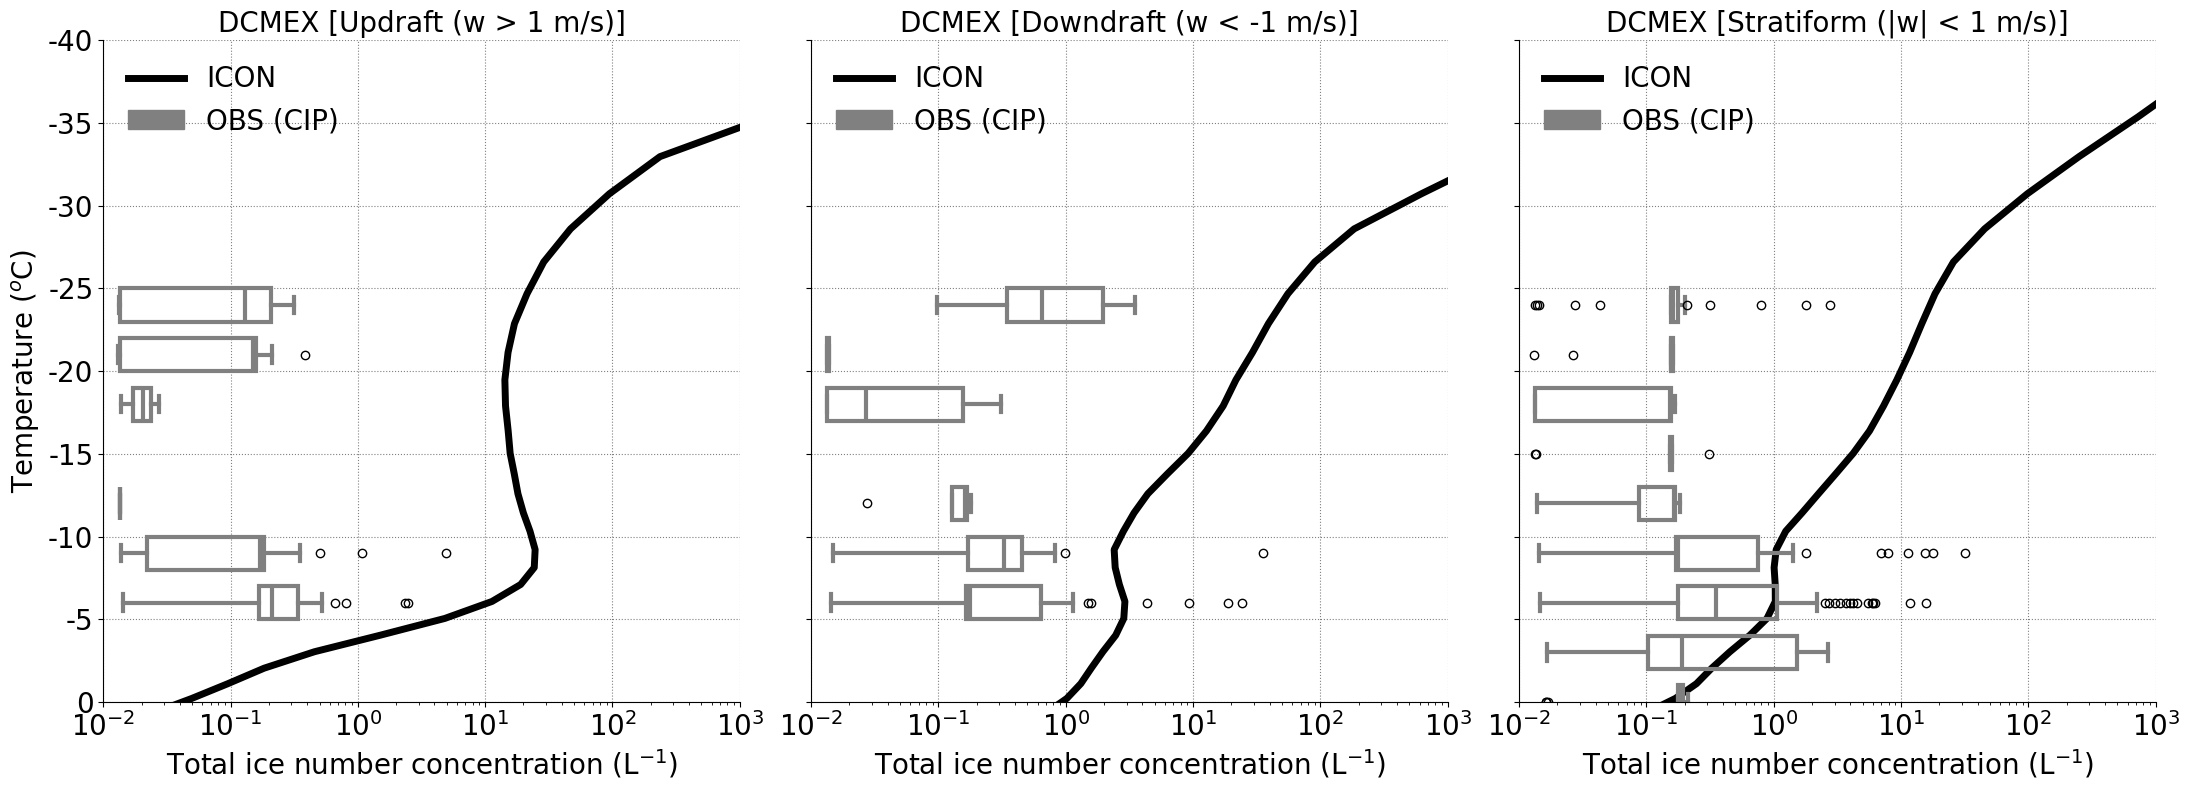

In [26]:


fontsize = 20;
linewidth = 3;
width=2;
alpha=1;

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['DCMEX [Updraft (w > 1 m/s)]', 'DCMEX [Downdraft (w < -1 m/s)]', 'DCMEX [Stratiform (|w| < 1 m/s)]']

for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(tinc_up_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_up_by_bin, positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 1:
        ax.plot(tinc_dn_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_dn_by_bin, positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 2:
        ax.plot(tinc_st_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_st_by_bin, positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-2, 1.e3)
    ax.set_ylim(0, -40)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Total ice number concentration (L$^{-1}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_cip_patch = mpatches.Patch(color='grey', label='OBS (CIP)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_cip_patch], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()


In [27]:

# for the operation below, see the ncdump -h mas-2ds_faam_20220802*.nc and emails by Blyth and Finney

twods = xr.Dataset({"time": ("time", pd.date_range("1970-01-01", periods=14604, freq="S"))})
attrs = {"description": "Adjusted time values", "source": "Generated by script"}

ts = xr.Dataset({"time": ("time", twods['time'].values + pd.Timedelta(1659454542.,unit='s'), attrs)})
twods['time'] = ts['time']

ds_2ds  = xr.open_mfdataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/man-2ds_faam_20220802_v001_r0_c310.nc', group='ch1')
ds_2ds['time'] = ts['time']

# Total ice concentrations
ds_2ds['tot_inc_perl'] = ds_2ds.total_number_concentration_of_ambient_MI_particles_in_air + ds_2ds.total_number_concentration_of_ambient_HI_particles_in_air


time_2ds = pd.to_datetime(ds_2ds['time'].values)
time_core = pd.to_datetime(data_faam_core_1hz_new['time'].values)

common_times = time_2ds[time_2ds.isin(time_core)]

# Now select data_faam_cpi where time is in common_times
ds_core_1hz_new = data_faam_core_1hz_new.sel(time=common_times)
ds_2ds_new = ds_2ds.sel(time=common_times)

#ds_2ds_new = xr.merge([ds_faam_1hz_2ds, ds_2ds])
ds_2ds_new['TAT_DI_R'] = ds_core_1hz_new['TAT_DI_R']
ds_2ds_new['W_C'] = ds_core_1hz_new['W_C']
ds_2ds_new['TAS'] = ds_core_1hz_new['TAS']
ds_2ds_new['tempc'] = ds_2ds_new['TAT_DI_R']-273.16

# As per Alan Blyth and Finney, UniLeeds (see emails)
ds_2ds_new['tot_inc_perl'] = ds_2ds_new['tot_inc_perl']*60./ds_2ds_new.TAS 

# Profiles for the updrafts, downdrafts and stratiform regions
filt_tot2ds_up_cond = (ds_2ds_new.tot_inc_perl > 0.) & (ds_2ds_new.W_C > 1.)
filt_tot2ds_dn_cond = (ds_2ds_new.tot_inc_perl > 0.) & (ds_2ds_new.W_C < -1.)
filt_tot2ds_st_cond = (ds_2ds_new.tot_inc_perl > 0.) & (np.abs(ds_2ds_new.W_C) < 1.)

# store variables
ds_2ds_new['tot_inc_up_perl'] = xr.where(filt_tot2ds_up_cond, ds_2ds_new.tot_inc_perl, np.nan)
ds_2ds_new['tot_inc_dn_perl'] = xr.where(filt_tot2ds_dn_cond, ds_2ds_new.tot_inc_perl, np.nan)
ds_2ds_new['tot_inc_st_perl'] = xr.where(filt_tot2ds_st_cond, ds_2ds_new.tot_inc_perl, np.nan)

# Define temperature bins
temp_2ds_bin = np.array([0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_2ds_bin = np.sort(temp_2ds_bin)

tempc_values = ds_2ds_new['tempc'].values
nan_mask = np.isnan(tempc_values)

valid_tempc_values = tempc_values[~nan_mask]

# which temperature bin each 'ds_cip_new.tempc' value belongs to?
temp_bins_indices = np.digitize(valid_tempc_values, bins=np.append(temp_2ds_bin, np.inf)) - 1
temp_bins_indices = np.clip(temp_bins_indices, 0, len(temp_2ds_bin) - 1)

# assign temp_bin to temp_bin_labels
temp_bin_labels = temp_2ds_bin[temp_bins_indices]
temp_bin_labels_full = np.full_like(tempc_values, np.nan)
temp_bin_labels_full[~nan_mask] = temp_bin_labels

time_coord = ds_2ds_new['tempc'].coords['time']
ds_2ds_new['temp_2ds_bin'] = xr.DataArray(temp_bin_labels_full, coords={'time': time_coord}, dims=['time'])

df_up_2ds = ds_2ds_new[['tot_inc_up_perl', 'temp_2ds_bin']].to_dataframe().dropna()
df_dn_2ds = ds_2ds_new[['tot_inc_dn_perl', 'temp_2ds_bin']].to_dataframe().dropna()
df_st_2ds = ds_2ds_new[['tot_inc_st_perl', 'temp_2ds_bin']].to_dataframe().dropna()

df_up_2ds = df_up_2ds.dropna(subset=['temp_2ds_bin'])
df_dn_2ds = df_dn_2ds.dropna(subset=['temp_2ds_bin'])
df_st_2ds = df_st_2ds.dropna(subset=['temp_2ds_bin'])

# Sort the data by bin
updraft_2ds_by_bin = [df_up_2ds[df_up_2ds['temp_2ds_bin'] == temp]['tot_inc_up_perl'].values for temp in temp_2ds_bin]
downdraft_2ds_by_bin = [df_dn_2ds[df_dn_2ds['temp_2ds_bin'] == temp]['tot_inc_dn_perl'].values for temp in temp_2ds_bin]
stratiform_2ds_by_bin = [df_st_2ds[df_st_2ds['temp_2ds_bin'] == temp]['tot_inc_st_perl'].values for temp in temp_2ds_bin]


/tmp/ipykernel_3650128/1619760065.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  twods = xr.Dataset({"time": ("time", pd.date_range("1970-01-01", periods=14604, freq="S"))})


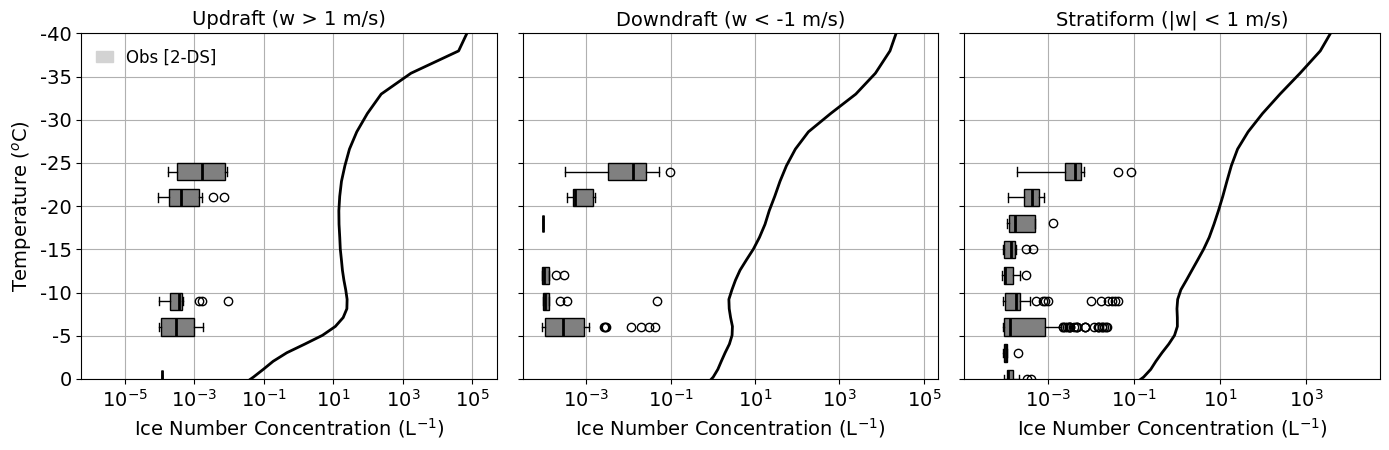

In [20]:
# Plot ice number concentrations
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
plot_titles = ['Updraft (w > 1 m/s)', 'Downdraft (w < -1 m/s)', 'Stratiform (|w| < 1 m/s)']
data_list = [updraft_2ds_by_bin, downdraft_2ds_by_bin, stratiform_2ds_by_bin]
temp_bins_list = [temp_cip_bin, temp_cip_bin, temp_cip_bin]

fontsize = 14
for i, ax in enumerate(axes):
    temp_bins = temp_bins_list[i]
    data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(tinc_up_2mom, tempc_2mom, 'k-', linewidth=2.0, label='ICON')
    elif i == 1:
        ax.plot(tinc_dn_2mom, tempc_2mom, 'k-', linewidth=2.0, label='ICON')
    elif i == 2:
        ax.plot(tinc_st_2mom, tempc_2mom, 'k-', linewidth=2.0, label='ICON')

    # Plot boxplots
    for j, data in enumerate(data_by_bin):
        if len(data) > 0:
            ax.boxplot(data, positions=[temp_bins[j]], vert=False, patch_artist=True,
                       widths=2.0,  # Increase box width for better visibility
                       boxprops=dict(facecolor='grey', linewidth=1.0),  # Thicker box edges
                       medianprops=dict(color='black', linewidth=2.0),  # Highlight median
                       whiskerprops=dict(linewidth=1.0),  # Thicker whiskers
                       capprops=dict(linewidth=1.0))  # Thicker caps

    # Labels and settings for each subplot
    ax.set_xscale('log')
    #ax.set_xlim(1.e-2, 1.e2)
    ax.set_ylim(0, -40)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice Number Concentration (L$^{-1}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True)

axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

# legend for observations
obs_patch = mpatches.Patch(color='lightgrey', label='Obs [2-DS]')
axes[0].legend(handles=[obs_patch], frameon=False, handlelength=1, labelspacing=0.001,
                ncol=1, fontsize=12, loc='upper left')

#plt.suptitle('DCMEX (02 August 2022)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [28]:

time_nev = pd.to_datetime(data_faam_nevrozov['Time'].values)
time_core = pd.to_datetime(data_faam_core_1hz['Time'].values)

common_times = time_nev[time_nev.isin(time_core)]

# Now select data_faam_cpi where time is in common_times
#ds_core_1hz_new = data_faam_core_1hz_new.sel(time=common_times)

ds_faam_core_new = data_faam_core_1hz.sel(Time=common_times)
ds_nev_new = data_faam_nevrozov.sel(Time=common_times)

ds_nev_new = xr.merge([ds_faam_core_new, ds_nev_new])

ds_nev_new['tempc'] = ds_nev_new['TAT_DI_R']-273.16


filt_lwc_nev_up_cond = (ds_nev_new.LWC1 > 1.e-6) & (ds_nev_new.W_C > 1.)
filt_lwc_nev_dn_cond = (ds_nev_new.LWC1 > 1.e-6) & (ds_nev_new.W_C < -1.)
filt_lwc_nev_st_cond = (ds_nev_new.LWC1 > 1.e-6) & (np.abs(ds_nev_new.W_C) < 1.)

filt_iwc_nev_up_cond = (ds_nev_new.IWC1 > 1.e-6) & (ds_nev_new.W_C > 1.)
filt_iwc_nev_dn_cond = (ds_nev_new.IWC1 > 1.e-6) & (ds_nev_new.W_C < -1.)
filt_iwc_nev_st_cond = (ds_nev_new.IWC1 > 1.e-6) & (np.abs(ds_nev_new.W_C) < 1.)

# store variables
ds_nev_new['lwc_up_gperm3'] = xr.where(filt_lwc_nev_up_cond, ds_nev_new.LWC1, np.nan)
ds_nev_new['lwc_dn_gperm3'] = xr.where(filt_lwc_nev_dn_cond, ds_nev_new.LWC1, np.nan)
ds_nev_new['lwc_st_gperm3'] = xr.where(filt_lwc_nev_st_cond, ds_nev_new.LWC1, np.nan)

ds_nev_new['iwc_up_gperm3'] = xr.where(filt_iwc_nev_up_cond, ds_nev_new.IWC1, np.nan)
ds_nev_new['iwc_dn_gperm3'] = xr.where(filt_iwc_nev_dn_cond, ds_nev_new.IWC1, np.nan)
ds_nev_new['iwc_st_gperm3'] = xr.where(filt_iwc_nev_st_cond, ds_nev_new.IWC1, np.nan)

# Define temperature bins
temp_nev_bin = np.array([30., 27., 24., 21., 18., 15., 12., 9., 6., 3., 0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_nev_bin = np.sort(temp_nev_bin)

tempc_values = ds_nev_new['tempc'].values
nan_mask = np.isnan(tempc_values)

valid_tempc_values = tempc_values[~nan_mask]

# which temperature bin each 'ds_cip_new.tempc' value belongs to?
temp_bins_indices = np.digitize(valid_tempc_values, bins=np.append(temp_nev_bin, np.inf)) - 1
temp_bins_indices = np.clip(temp_bins_indices, 0, len(temp_nev_bin) - 1)

# assign temp_bin to temp_bin_labels
temp_bin_labels = temp_nev_bin[temp_bins_indices]
temp_bin_labels_full = np.full_like(tempc_values, np.nan)
temp_bin_labels_full[~nan_mask] = temp_bin_labels

time_coord = ds_nev_new['tempc'].coords['Time']
ds_nev_new['temp_nev_bin'] = xr.DataArray(temp_bin_labels_full, coords={'Time': time_coord}, dims=['Time'])

df_up_lwc_nev = ds_nev_new[['lwc_up_gperm3', 'temp_nev_bin']].to_dataframe().dropna()
df_dn_lwc_nev = ds_nev_new[['lwc_dn_gperm3', 'temp_nev_bin']].to_dataframe().dropna()
df_st_lwc_nev = ds_nev_new[['lwc_st_gperm3', 'temp_nev_bin']].to_dataframe().dropna()

df_up_iwc_nev = ds_nev_new[['iwc_up_gperm3', 'temp_nev_bin']].to_dataframe().dropna()
df_dn_iwc_nev = ds_nev_new[['iwc_dn_gperm3', 'temp_nev_bin']].to_dataframe().dropna()
df_st_iwc_nev = ds_nev_new[['iwc_st_gperm3', 'temp_nev_bin']].to_dataframe().dropna()

df_up_lwc_nev = df_up_lwc_nev.dropna(subset=['temp_nev_bin'])
df_dn_lwc_nev = df_dn_lwc_nev.dropna(subset=['temp_nev_bin'])
df_st_lwc_nev = df_st_lwc_nev.dropna(subset=['temp_nev_bin'])

df_up_iwc_nev = df_up_iwc_nev.dropna(subset=['temp_nev_bin'])
df_dn_iwc_nev = df_dn_iwc_nev.dropna(subset=['temp_nev_bin'])
df_st_iwc_nev = df_st_iwc_nev.dropna(subset=['temp_nev_bin'])

# Sort the data by bin
lwc_nev_up_by_bin = [df_up_lwc_nev[df_up_lwc_nev['temp_nev_bin'] == temp]['lwc_up_gperm3'].values for temp in temp_nev_bin]
lwc_nev_dn_by_bin = [df_dn_lwc_nev[df_dn_lwc_nev['temp_nev_bin'] == temp]['lwc_dn_gperm3'].values for temp in temp_nev_bin]
lwc_nev_st_by_bin = [df_st_lwc_nev[df_st_lwc_nev['temp_nev_bin'] == temp]['lwc_st_gperm3'].values for temp in temp_nev_bin]

iwc_nev_up_by_bin = [df_up_iwc_nev[df_up_iwc_nev['temp_nev_bin'] == temp]['iwc_up_gperm3'].values for temp in temp_nev_bin]
iwc_nev_dn_by_bin = [df_dn_iwc_nev[df_dn_iwc_nev['temp_nev_bin'] == temp]['iwc_dn_gperm3'].values for temp in temp_nev_bin]
iwc_nev_st_by_bin = [df_st_iwc_nev[df_st_iwc_nev['temp_nev_bin'] == temp]['iwc_st_gperm3'].values for temp in temp_nev_bin]


In [29]:


# lwc gperm3
filt_lwc_up_perl = xr.where((ds_2mom_new.lwc_gperm3 > 1.e-6) & (ds_2mom_new.w_vel > 1.), ds_2mom_new.lwc_gperm3, np.nan)
filt_lwc_dn_perl = xr.where((ds_2mom_new.lwc_gperm3 > 1.e-6) & (ds_2mom_new.w_vel < -1.), ds_2mom_new.lwc_gperm3, np.nan)
filt_lwc_st_perl = xr.where((ds_2mom_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_2mom_new.w_vel) < 1.), ds_2mom_new.lwc_gperm3, np.nan)

lwc_up_2mom = filt_lwc_up_perl.mean(dim=('time','ncells'))
lwc_dn_2mom = filt_lwc_dn_perl.mean(dim=('time','ncells'))
lwc_st_2mom = filt_lwc_st_perl.mean(dim=('time','ncells'))

tempc_2mom = ds_2mom_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up_perl = xr.where((ds_2mom_new.tiwc_gperm3 > 1.e-6) & (ds_2mom_new.w_vel > 1.), ds_2mom_new.tiwc_gperm3, np.nan)
filt_tiwc_dn_perl = xr.where((ds_2mom_new.tiwc_gperm3 > 1.e-6) & (ds_2mom_new.w_vel < -1.), ds_2mom_new.tiwc_gperm3, np.nan)
filt_tiwc_st_perl = xr.where((ds_2mom_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_2mom_new.w_vel) < 1.), ds_2mom_new.tiwc_gperm3, np.nan)

tiwc_up_2mom = filt_tiwc_up_perl.mean(dim=('time','ncells'))
tiwc_dn_2mom = filt_tiwc_dn_perl.mean(dim=('time','ncells'))
tiwc_st_2mom = filt_tiwc_st_perl.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up_perl = xr.where((ds_2mom_new.cdnc_percm3 > 1.e-6) & (ds_2mom_new.w_vel > 1.), ds_2mom_new.cdnc_percm3, np.nan)
filt_cdnc_dn_perl = xr.where((ds_2mom_new.cdnc_percm3 > 1.e-6) & (ds_2mom_new.w_vel < -1.), ds_2mom_new.cdnc_percm3, np.nan)
filt_cdnc_st_perl = xr.where((ds_2mom_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_2mom_new.w_vel) < 1.), ds_2mom_new.cdnc_percm3, np.nan)

cdnc_up_2mom = filt_cdnc_up_perl.mean(dim=('time','ncells'))
cdnc_dn_2mom = filt_cdnc_dn_perl.mean(dim=('time','ncells'))
cdnc_st_2mom = filt_cdnc_st_perl.mean(dim=('time','ncells'))


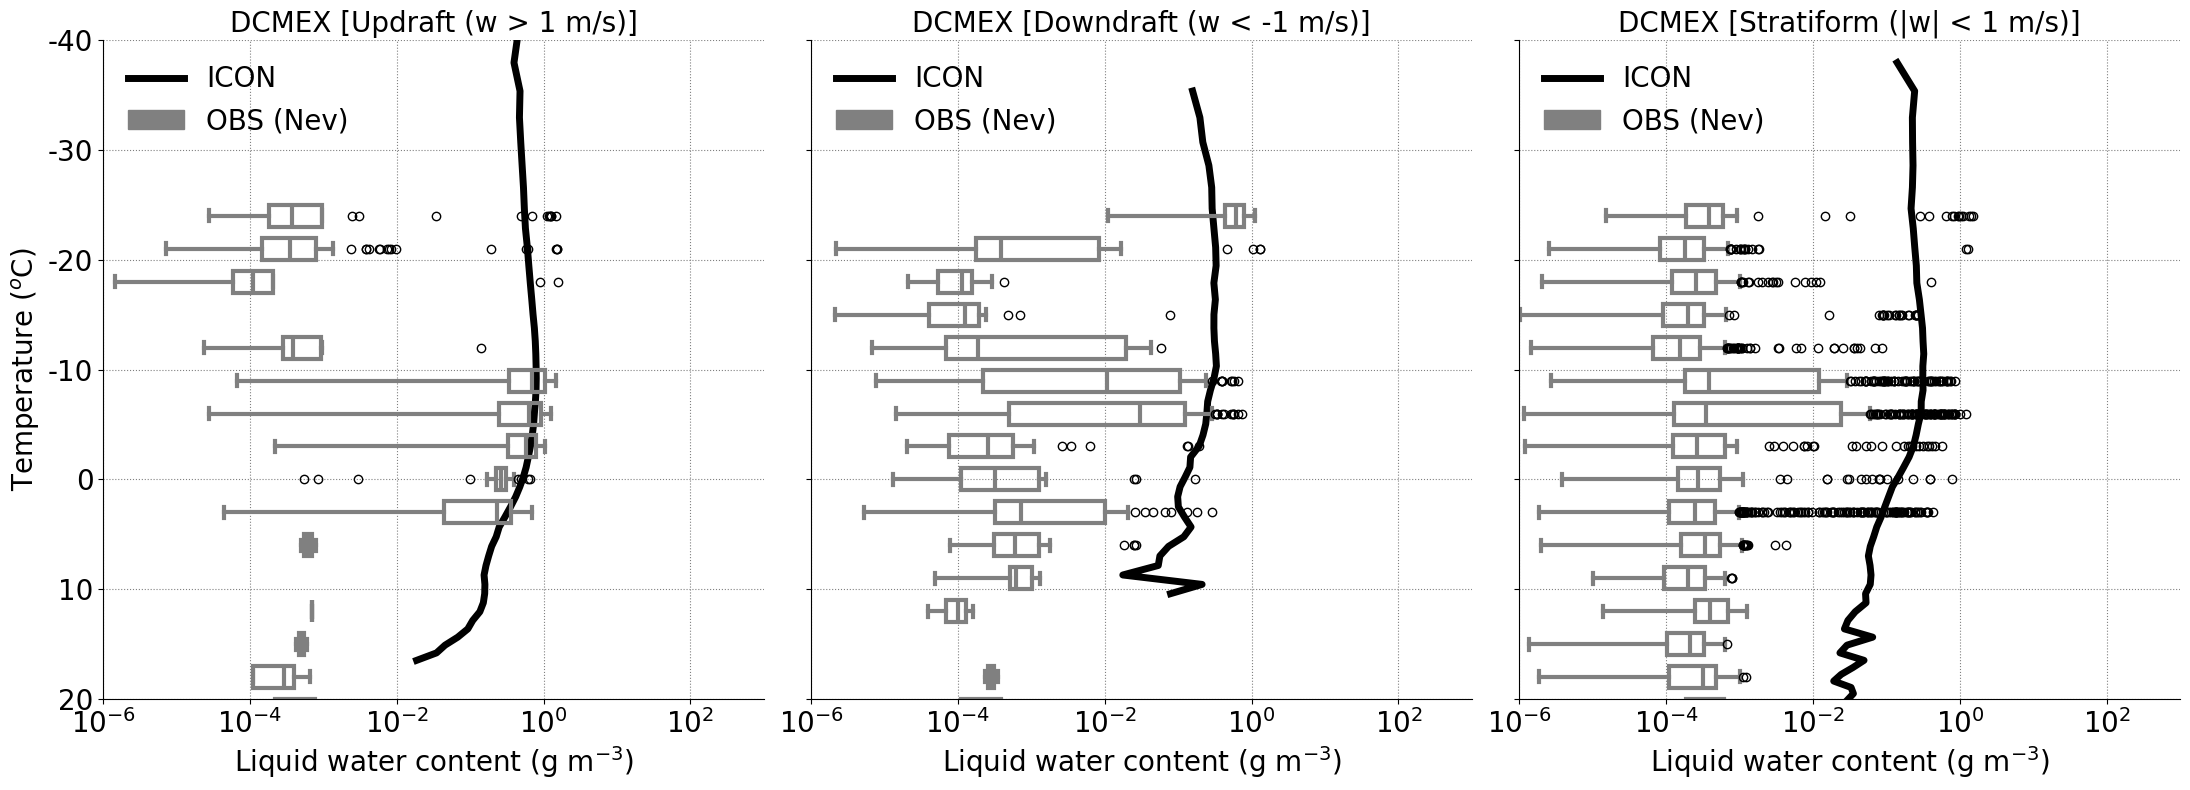

In [30]:


fontsize = 20;
linewidth = 3;
width=2;
alpha=1;

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['DCMEX [Updraft (w > 1 m/s)]', 'DCMEX [Downdraft (w < -1 m/s)]', 'DCMEX [Stratiform (|w| < 1 m/s)]']

for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(lwc_up_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_nev_up_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 1:
        ax.plot(lwc_dn_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_nev_dn_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 2:
        ax.plot(lwc_st_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_nev_st_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-6, 1.e2)
    ax.set_ylim(20, -40)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_cip_patch = mpatches.Patch(color='grey', label='OBS (Nev)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_cip_patch], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()


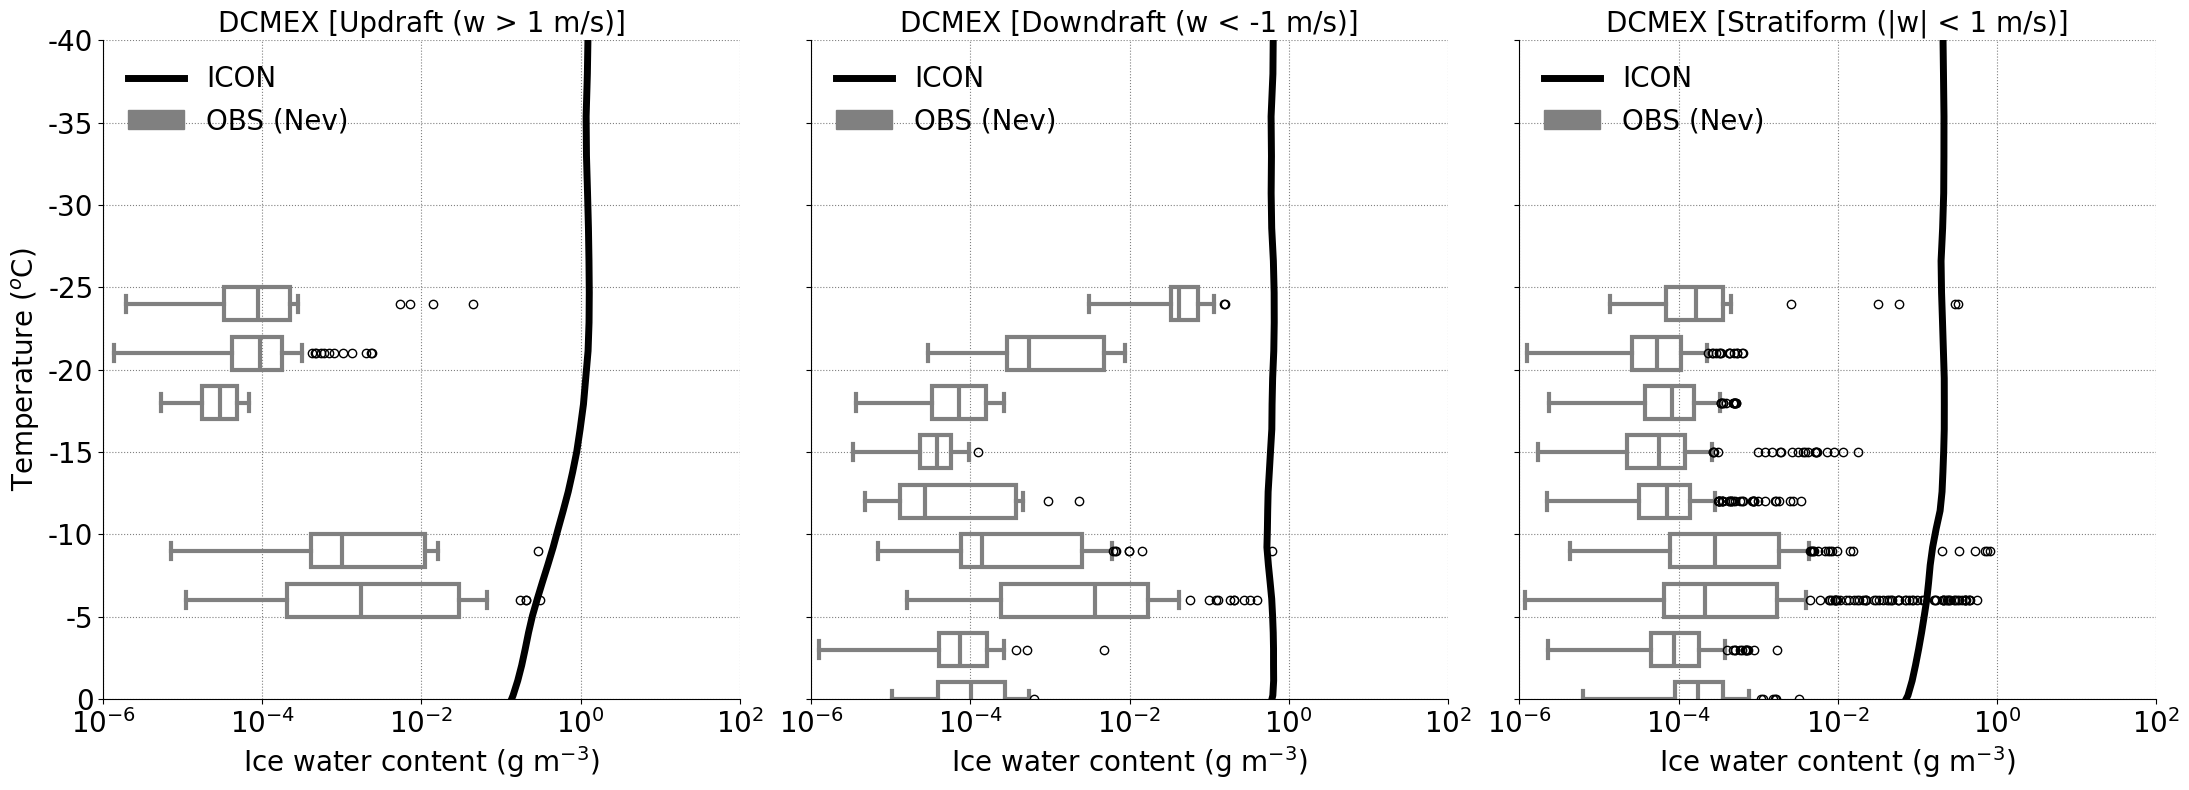

In [32]:


fontsize = 20;
linewidth = 3;
width=2;
alpha=1;

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['DCMEX [Updraft (w > 1 m/s)]', 'DCMEX [Downdraft (w < -1 m/s)]', 'DCMEX [Stratiform (|w| < 1 m/s)]']

for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(tiwc_up_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_nev_up_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 1:
        ax.plot(tiwc_dn_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_nev_dn_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 2:
        ax.plot(tiwc_st_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_nev_st_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-6, 1.e2)
    ax.set_ylim(0, -40)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_cip_patch = mpatches.Patch(color='grey', label='OBS (Nev)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_cip_patch], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()


In [33]:
ds_faam_cdp_phy = data_faam_core_cld_phy

ds_faam_cdp_phy['CDP_TSPM'] = ds_faam_cdp_phy['CDP_TSPM'].dt.floor('s')
ds_faam_cdp_phy['cdnc_percm3'] = ds_faam_cdp_phy['CDP_CONC'].rename({'CDP_TSPM': 'Time'})



ds_faam_cdp_phy['TAT_DI_R'] = data_faam_core_1hz['TAT_DI_R']
ds_faam_cdp_phy['W_C'] = data_faam_core_1hz['W_C']
ds_faam_cdp_phy['tempc'] = data_faam_core_1hz.TAT_DI_R-273.16

filt_cdnc_cdp_up_cond = (ds_faam_cdp_phy.cdnc_percm3 > 1.e-1) & (ds_faam_cdp_phy.W_C > 1.)
filt_cdnc_cdp_dn_cond = (ds_faam_cdp_phy.cdnc_percm3 > 1.e-1) & (ds_faam_cdp_phy.W_C < -1.) & (ds_faam_cdp_phy.W_C > -20.)
filt_cdnc_cdp_st_cond = (ds_faam_cdp_phy.cdnc_percm3 > 1.e-1) & (np.abs(ds_faam_cdp_phy.W_C) < 1.)

# store variables
ds_faam_cdp_phy['cdnc_up_percm3'] = xr.where(filt_cdnc_cdp_up_cond, ds_faam_cdp_phy.cdnc_percm3, np.nan)
ds_faam_cdp_phy['cdnc_dn_percm3'] = xr.where(filt_cdnc_cdp_dn_cond, ds_faam_cdp_phy.cdnc_percm3, np.nan)
ds_faam_cdp_phy['cdnc_st_percm3'] = xr.where(filt_cdnc_cdp_st_cond, ds_faam_cdp_phy.cdnc_percm3, np.nan)

print(ds_faam_cdp_phy.Time)
# Define temperature bins
temp_cdp_bin = np.array([30., 27., 24., 21., 18., 15., 12., 9., 6., 3., 0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_cdp_bin = np.sort(temp_cdp_bin)

tempc_values = ds_faam_cdp_phy['tempc'].values
nan_mask = np.isnan(tempc_values)

valid_tempc_values = tempc_values[~nan_mask]

# which temperature bin each 'ds_cip_new.tempc' value belongs to?
temp_bins_indices = np.digitize(valid_tempc_values, bins=np.append(temp_cdp_bin, np.inf)) - 1
temp_bins_indices = np.clip(temp_bins_indices, 0, len(temp_cdp_bin) - 1)

# assign temp_bin to temp_bin_labels
temp_bin_labels = temp_cdp_bin[temp_bins_indices]
temp_bin_labels_full = np.full_like(tempc_values, np.nan)
temp_bin_labels_full[~nan_mask] = temp_bin_labels

time_coord = ds_faam_cdp_phy['tempc'].coords['Time']
ds_faam_cdp_phy['temp_cdp_bin'] = xr.DataArray(temp_bin_labels_full, coords={'Time': time_coord}, dims=['Time'])

df_up_cdnc_cdp = ds_faam_cdp_phy[['cdnc_up_percm3', 'temp_cdp_bin']].to_dataframe().dropna()
df_dn_cdnc_cdp = ds_faam_cdp_phy[['cdnc_dn_percm3', 'temp_cdp_bin']].to_dataframe().dropna()
df_st_cdnc_cdp = ds_faam_cdp_phy[['cdnc_st_percm3', 'temp_cdp_bin']].to_dataframe().dropna()

df_up_cdnc_cdp = df_up_cdnc_cdp.dropna(subset=['temp_cdp_bin'])
df_dn_cdnc_cdp = df_dn_cdnc_cdp.dropna(subset=['temp_cdp_bin'])
df_st_cdnc_cdp = df_st_cdnc_cdp.dropna(subset=['temp_cdp_bin'])

# Sort the data by bin
cdnc_cdp_up_by_bin = [df_up_cdnc_cdp[df_up_cdnc_cdp['temp_cdp_bin'] == temp]['cdnc_up_percm3'].values for temp in temp_cdp_bin]
cdnc_cdp_dn_by_bin = [df_dn_cdnc_cdp[df_dn_cdnc_cdp['temp_cdp_bin'] == temp]['cdnc_dn_percm3'].values for temp in temp_cdp_bin]
cdnc_cdp_st_by_bin = [df_st_cdnc_cdp[df_st_cdnc_cdp['temp_cdp_bin'] == temp]['cdnc_st_percm3'].values for temp in temp_cdp_bin]

<xarray.DataArray 'Time' (Time: 24313)>
array(['2022-08-02T13:26:01.000000000', '2022-08-02T13:26:02.000000000',
       '2022-08-02T13:26:03.000000000', ..., '2022-08-02T20:11:11.000000000',
       '2022-08-02T20:11:12.000000000', '2022-08-02T20:11:13.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2022-08-02T13:26:01 ... 2022-08-02T20:11:13
    LAT_GIN  (Time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    LON_GIN  (Time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan


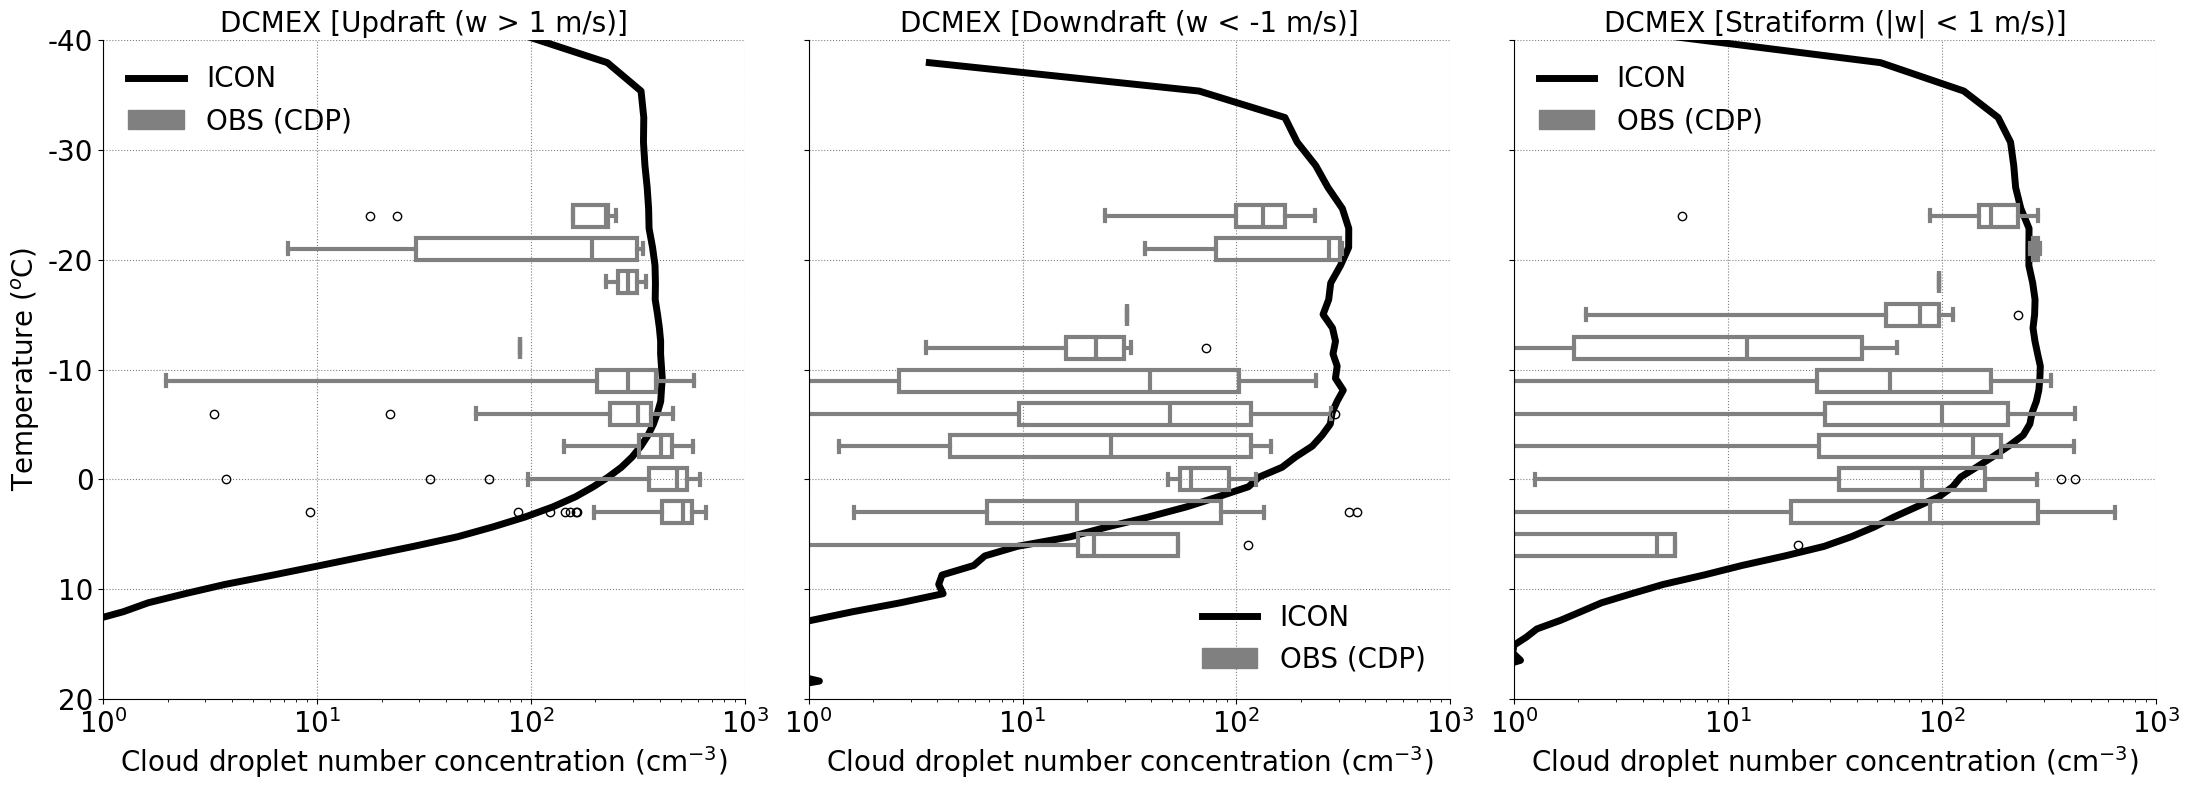

In [34]:


fontsize = 20;
linewidth = 3;
width=2;
alpha=1;

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['DCMEX [Updraft (w > 1 m/s)]', 'DCMEX [Downdraft (w < -1 m/s)]', 'DCMEX [Stratiform (|w| < 1 m/s)]']

for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(cdnc_up_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_up_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 1:
        ax.plot(cdnc_dn_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_dn_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 2:
        ax.plot(cdnc_st_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_st_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e0, 1.e3)
    ax.set_ylim(20, -40)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud droplet number concentration (cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_cip_patch = mpatches.Patch(color='grey', label='OBS (CDP)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_cip_patch], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()


In [40]:

print(ds_faam_cdp_phy.CDP_TSPM)
print(ds_faam_cdp_phy.Time)
print(ds_faam_cdp_phy.cdnc_percm3.Time)
print(ds_faam_cdp_phy.tempc.Time)
print(ds_faam_cdp_phy.W_C.Time)

<xarray.DataArray 'CDP_TSPM' (CDP_TSPM: 24313)>
array(['2022-08-02T13:26:01.882812500', '2022-08-02T13:26:02.882812500',
       '2022-08-02T13:26:03.882812500', ..., '2022-08-02T20:11:11.500000000',
       '2022-08-02T20:11:12.500000000', '2022-08-02T20:11:13.500000000'],
      dtype='datetime64[ns]')
Coordinates:
  * CDP_TSPM  (CDP_TSPM) datetime64[ns] 2022-08-02T13:26:01.882812500 ... 202...
Attributes:
    long_name:      Time UTC seconds past midnight for CDP
    standard_name:  time
    frequency:      1
    Number:         9999
<xarray.DataArray 'Time' (Time: 24313)>
array(['2022-08-02T13:26:01.000000000', '2022-08-02T13:26:02.000000000',
       '2022-08-02T13:26:03.000000000', ..., '2022-08-02T20:11:11.000000000',
       '2022-08-02T20:11:12.000000000', '2022-08-02T20:11:13.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2022-08-02T13:26:01 ... 2022-08-02T20:11:13
    LAT_GIN  (Time) float32 nan nan nan nan nan nan ... nan nan nan nan n

In [144]:

#filt_cdnc_cdp = xr.where((data_faam_core_cld_phy_new.CDP_CONC > 0.) & (data_faam_core_1hz.W_C > 1.), data_faam_core_cld_phy_new.CDP_CONC, np.nan)
#print(data_faam_core_cld_phy.Time)#_new





<xarray.DataArray 'Time' (Time: 24313)>
array(['2022-08-02T13:26:01.000000000', '2022-08-02T13:26:02.000000000',
       '2022-08-02T13:26:03.000000000', ..., '2022-08-02T20:11:11.000000000',
       '2022-08-02T20:11:12.000000000', '2022-08-02T20:11:13.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2022-08-02T13:26:01 ... 2022-08-02T20:11:13
    LAT_GIN  (Time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    LON_GIN  (Time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan


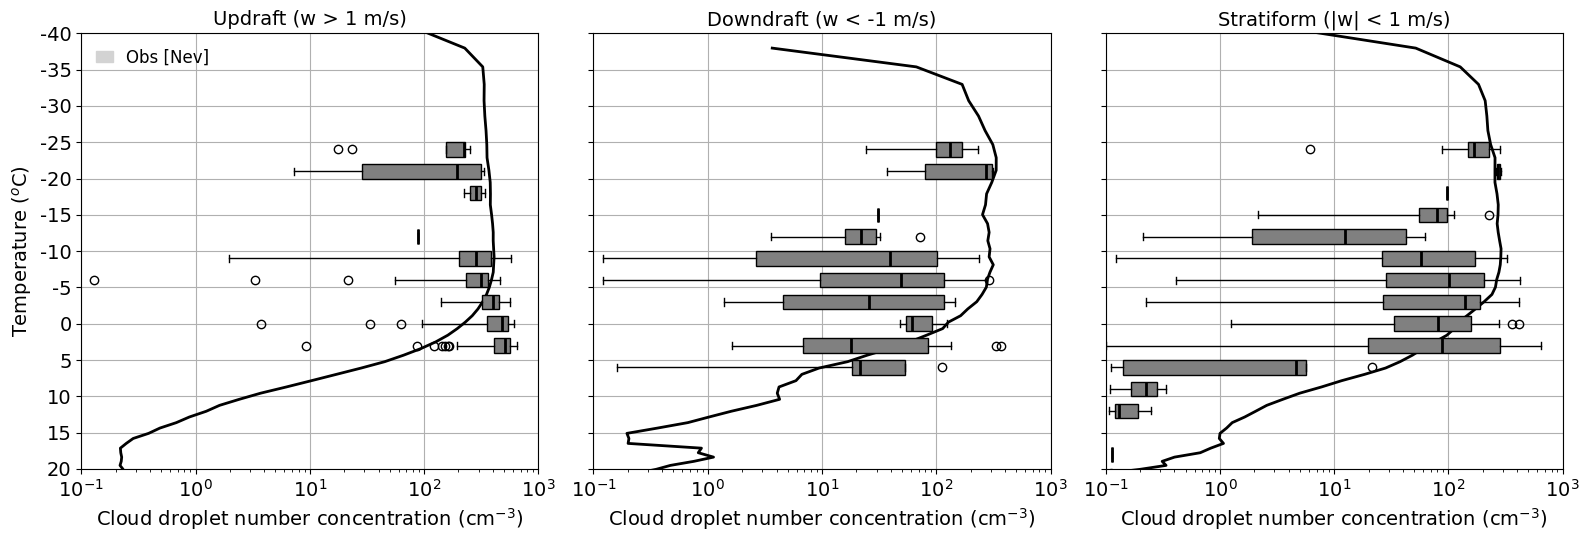

In [147]:
# Plot ice number concentrations
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
plot_titles = ['Updraft (w > 1 m/s)', 'Downdraft (w < -1 m/s)', 'Stratiform (|w| < 1 m/s)']
data_list = [updraft_cdnc_cdp_by_bin, downdraft_cdnc_cdp_by_bin, stratiform_cdnc_cdp_by_bin]
temp_bins_list = [temp_cdp_bin, temp_cdp_bin, temp_cdp_bin]

fontsize = 14
for i, ax in enumerate(axes):
    temp_bins = temp_bins_list[i]
    data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(cdnc_up_2mom, tempc_2mom, 'k-', linewidth=2.0, label='ICON')
    elif i == 1:
        ax.plot(cdnc_dn_2mom, tempc_2mom, 'k-', linewidth=2.0, label='ICON')
    elif i == 2:
        ax.plot(cdnc_st_2mom, tempc_2mom, 'k-', linewidth=2.0, label='ICON')

    # Plot boxplots
    for j, data in enumerate(data_by_bin):
        if len(data) > 0:
            ax.boxplot(data, positions=[temp_bins[j]], vert=False, patch_artist=True,
                       widths=2.0,  # Increase box width for better visibility
                       boxprops=dict(facecolor='grey', linewidth=1.0),  # Thicker box edges
                       medianprops=dict(color='black', linewidth=2.0),  # Highlight median
                       whiskerprops=dict(linewidth=1.0),  # Thicker whiskers
                       capprops=dict(linewidth=1.0))  # Thicker caps

    # Labels and settings for each subplot
    ax.set_xscale('log')
    ax.set_xlim(1.e-1, 1.e3)
    ax.set_ylim(20, -40)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud droplet number concentration (cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True)

axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['20', '15', '10', '5', '0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

# legend for observations
obs_patch = mpatches.Patch(color='lightgrey', label='Obs [Nev]')
axes[0].legend(handles=[obs_patch], frameon=False, handlelength=1, labelspacing=0.001,
                ncol=1, fontsize=12, loc='upper left')

#plt.suptitle('DCMEX (02 August 2022)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()